In [1]:
import os
import pdb
import torch
import torch.nn as nn
import numpy as np
import pyro
import pyro.distributions as dist
import matplotlib.pyplot as plt

from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, config_enumerate, TraceMeanField_ELBO
from pyro.optim import PyroLRScheduler, ClippedAdam
from torch.optim.lr_scheduler import StepLR
from pyro import poutine
from pyro.infer import Predictive, infer_discrete

from bnpvae import DPMM, mix_weights


def create_sim_data(mu, sd, n_sim):
#     samples = dist.Normal(mu, sd).to_event(1).sample([n_sim])
    samples = dist.Normal(mu, sd).sample([n_sim])
    return samples


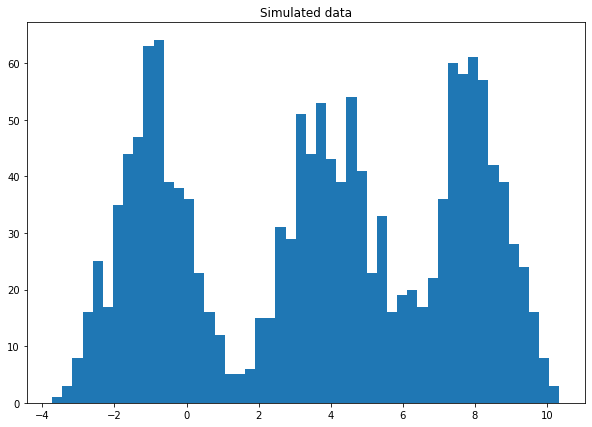

In [9]:
pyro.clear_param_store()

# Simulate data
num_sample = 500
# loc = torch.tensor([[1, 1],
#                     [-4, -2]]).float()
loc = torch.tensor([[4],
                    [-1],[8]]).float()
scale = torch.ones(1).float()
data = create_sim_data(loc, scale, num_sample)
x_data = torch.cat([data[:, 0], data[:, 1], data[:,2]], dim=0)

plt.figure(figsize=(10, 7))
# plt.scatter(data[:, 0][:, 0], data[:, 0][:, 1], color='red')
# plt.scatter(data[:, 1][:, 0], data[:, 1][:, 1], color='blue')
plt.hist(x_data[:,0], bins=50)
plt.title("Simulated data")
# plt.show()
plt.savefig("sim_data.png", bbox_inches="tight")

In [3]:
mu_init = torch.tensor([[4],
                        [-4],[0],[10]]).float()
sd_q1 = torch.ones_like(mu_init)*0.5
sd_q2 = torch.ones_like(mu_init)*0.3
pi_c = dist.Dirichlet(1/4 * torch.ones(4)).sample([x_data.size(0)])
prior_val = {"mu_c": mu_init, "sd_q1": sd_q1, "sd_q2": sd_q1, "pi_c":pi_c}

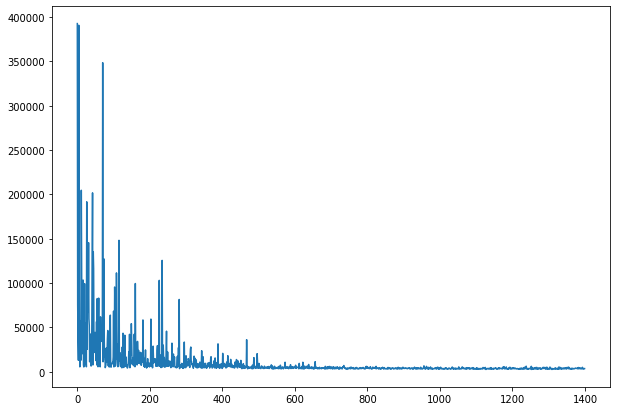

In [4]:
pyro.clear_param_store()
losses=[]
num_init_comp = 4
batch_size = 200
n_epoch = 200
model = DPMM(latent_dim=1, num_T=num_init_comp, init_prior=prior_val, num_obs=x_data.size(0))
optimizer = torch.optim.Adam
scheduler = PyroLRScheduler(StepLR, {'optimizer': optimizer,
                                     'optim_args': {'lr': 0.05, 'betas':[0.9,0.95]},
                                     'gamma': 0.5, "step_size": 100},{"clip_norm": 1.})

# scheduler = PyroLRScheduler(StepLR, {'optimizer': optimizer,
#                                      'optim_args': {'lr': 0.01, 'betas':[0.9,0.95]},
#                                      'gamma': 0.9, "step_size": 100})


basic_svi = SVI(config_enumerate(model.model), config_enumerate(model.guide), scheduler, loss=TraceEnum_ELBO(max_plate_nesting=1))
# basic_svi = SVI(model.model, model.guide, scheduler, loss=Trace_ELBO())

split_idx = torch.arange(0,x_data.size(0),batch_size)
rand_idx = torch.randperm(x_data.size(0))
for it in range(n_epoch):
    for ii in range(split_idx.size(0)-1):
        start_idx = split_idx[ii]
        end_idx = split_idx[ii+1]
        loss = basic_svi.step(x_data, rand_idx[start_idx:end_idx])
        losses.append(loss)

# for it in range(n_epoch):
#     loss = basic_svi.step(x_data)
#     losses.append(loss)

plt.figure(figsize=(10,7))
plt.plot(np.array(losses))
plt.show()

In [70]:
# Check weights allocation
torch.mean(pyro.param("pi_q"), dim=0)

tensor([0.2535, 0.4012, 0.1003, 0.2450], grad_fn=<MeanBackward1>)

In [5]:
# We can sample from posterior distribution like this (Posterior samples)
predictive = Predictive(model.model, guide=model.guide, num_samples=1000)
svi_samples = {key: value.detach().cpu() for key, value in predictive(x_data, torch.arange(x_data.size(0))).items()}

print(torch.mean(svi_samples["mu"], dim=0))
print(torch.mean(svi_samples["musd"], dim=0))

model.update_component_stats(svi_samples)

tensor([[ 4.4184],
        [-1.0950],
        [ 2.6289],
        [ 7.8099]])
tensor([[1.2604],
        [1.1652],
        [1.2383],
        [1.1951]])


In [6]:
# Generate new unseen data for testing
test_num = 50
data1 = create_sim_data(loc, scale*0.5, test_num)
test_data1 = torch.cat([data1[:, 0], data1[:, 1]], dim=0)

# Use the predict method in model to predict

In [160]:
weights = mix_weights(torch.mean(svi_samples["beta"], dim=0))
# mu_hat = torch.mean(svi_samples["mu"], dim=0)
# sigma_hat = torch.mean(svi_samples["musd"], dim=0)

# weights = mix_weights(1. / (1.+model.alpha_q.detach()))
mu_hat = model.mu_c.detach()
sigma_hat = model.component_sd

In [120]:
def mix_normal(mixture_weights, mu, sigma, samp):
    new_samp = samp.repeat(1,mu.size(0)).unsqueeze(2)
    return (mixture_weights * dist.Normal(mu, sigma).to_event(1).log_prob(new_samp).exp()).sum(-1)

In [8]:
model.component_weights

tensor([0.3418, 0.3955, 0.0658])

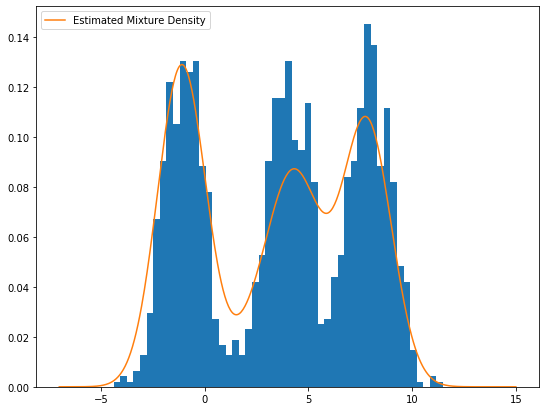

In [6]:
x_samples = torch.linspace(-7,15, steps=500)
norm_lik = model.likelihood(x_samples.unsqueeze(1))

plt.figure(figsize=(9,7))
plt.hist(x_data[:,0], bins=50, density=True)
plt.plot(x_samples, norm_lik, label="Estimated Mixture Density")
plt.legend()
plt.show()

In [30]:
# check component distance to be pruned
musd = torch.mean(svi_samples["musd"], dim=0)
mu_q = pyro.param("mu_q").detach()

kl_div = []
for ii in range(model.T):
    a_kl = []
    for nn in range(ii,model.T):
        def model_kl():
            mu = mu_q[ii]
            scale=musd[ii]
            pyro.sample("z_kl", dist.Normal(mu, scale))
            pyro.sample("obs_kl", dist.Normal(0.0, 2.0), obs=torch.tensor([0.3]))

        def guide_kl():
            mu = mu_q[nn]
            scale=musd[nn]
            pyro.sample("z_kl", dist.Normal(mu, scale))

        model_no_obs = poutine.block(model_kl, hide=["obs_kl"])
        optim = pyro.optim.Adam({"lr": 0.001})
        svi = SVI(model_no_obs, guide_kl, optim, TraceMeanField_ELBO())
        a_kl.append(svi.evaluate_loss())
    kl_div.append(a_kl)

print(kl_div)

[[0.0, 19.50234031677246, 12.888680458068848, 0.36218398809432983], [0.0, 0.634441077709198, 12.639073371887207], [0.0, 5.522141456604004], [0.0]]


In [34]:
c_idx = 1
val, merge_idx = torch.topk(torch.tensor(kl_div[c_idx]), 2, largest=False)

if val[1] < 1.0:
    merge_idx = merge_idx[1].item() + c_idx

    model.T = model.T - 1

    model.alpha_q.data = model.alpha_q.data[:-1]

    c_weight = torch.mean(pyro.param("pi_q").detach(),dim=0)[c_idx]
    m_weight = torch.mean(pyro.param("pi_q").detach(),dim=0)[merge_idx]
    total_weight = c_weight + m_weight

    model.pi_c.data[:, c_idx] = model.pi_c.data[:,merge_idx] + model.pi_c.data[:,c_idx]
    prune_mask = torch.arange(model.pi_c.size(1)) != merge_idx
    model.pi_c.data = model.pi_c.data[:,prune_mask]

    model.mu_c.data[c_idx] = (c_weight/total_weight)*model.mu_c.data[c_idx] + (m_weight/total_weight)*model.mu_c.data[merge_idx]
    model.sd_q1.data[c_idx] = (c_weight/total_weight)*model.sd_q1.data[c_idx] + (m_weight/total_weight)*model.sd_q1.data[merge_idx]
    model.sd_q2.data[c_idx] = (c_weight/total_weight)*model.sd_q2.data[c_idx] + (m_weight/total_weight)*model.sd_q2.data[merge_idx]
    model.component_sd[c_idx] = (c_weight/total_weight)*model.component_sd[c_idx] + (m_weight/total_weight)*model.component_sd[merge_idx]
    prune_mask = torch.arange(model.mu_c.size(0)) != merge_idx
    model.mu_c.data = model.mu_c.data[prune_mask]
    model.sd_q1.data = model.sd_q1.data[prune_mask]
    model.sd_q2.data = model.sd_q2.data[prune_mask]
    model.component_sd = model.component_sd[prune_mask]

    pyro.get_param_store()["alpha_q"] = model.alpha_q
    pyro.get_param_store()["pi_q"] = model.pi_c
    pyro.get_param_store()["mu_c"] = model.mu_c
    pyro.get_param_store()["sd_q1"] = model.sd_q1
    pyro.get_param_store()["sd_q2"] = model.sd_q2

In [35]:
model.component_sd

tensor([[1.3334],
        [1.5332]])

In [36]:
model.predict(test_data1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [12]:
model.predict(test_data1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1])

In [54]:
# This can be used for prediction too!

guide_trace = poutine.trace(model.guide).get_trace(x_data, torch.arange(100))  # record the globals
trained_model = poutine.replay(model.model, trace=guide_trace)  # replay the globals
inferred_model = infer_discrete(trained_model, temperature=1,
                                first_available_dim=-2)  # avoid conflict with data plate
# m1 = pyro.condition(inferred_model, data={"obs": test_data1})
trace = poutine.trace(inferred_model).get_trace(test_data1, torch.arange(test_data1.size(0)))

trace.nodes["cat"]

{'type': 'sample',
 'name': 'cat',
 'fn': Categorical(probs: torch.Size([100, 2])),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
         1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0,
         1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
         1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
         1, 1, 0, 0]),
 'infer': {'_dim_to_id': {}, '_dim_to_symbol': {-1: 'e'}},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (CondIndepStackFrame(name='data', dim=-1, size=100, counter=0),),
 'done': True,
 'stop': False,
 'continuation': None}

In [21]:
guide_trace = poutine.trace(model.guide).get_trace(x_data, torch.arange(100))  # record the globals
trained_model = poutine.replay(model.model, trace=guide_trace)  # replay the globals
inferred_model = infer_discrete(trained_model, temperature=1,
                                first_available_dim=-2)  # avoid conflict with data plate
trace = poutine.trace(inferred_model).get_trace(test_data1, torch.arange(100))

guide_trace.nodes["cat"]

{'type': 'sample',
 'name': 'cat',
 'fn': Categorical(probs: torch.Size([100, 2])),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor([0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1,
         0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
         0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
         0, 0, 0, 1]),
 'infer': {'_dim_to_id': {}, '_dim_to_symbol': {-1: 'e'}},
 'scale': 10.0,
 'mask': None,
 'cond_indep_stack': (CondIndepStackFrame(name='data', dim=-1, size=100, counter=0),),
 'done': True,
 'stop': False,
 'continuation': None}

# Test (Not Done)

In [37]:
test_num = 50
test_loc1 = torch.tensor([[5, -10],
                          [-10, 5]]).float()
data1 = create_sim_data(loc, scale, test_num)
data2 = create_sim_data(test_loc1, scale, test_num)
test_data1 = torch.cat([data1[:, 0], data1[:, 1]], dim=0)
test_data2 = torch.cat([data2[:, 0], data2[:, 1]], dim=0)

In [55]:
m1 = pyro.condition(model.model, data={"obs": test_data1})
m1_trace = poutine.trace(m1).get_trace(test_data1)
rp_m1 = poutine.replay(model.model, trace=m1_trace)
# m1_trace.compute_log_prob()
m1_trace.nodes["cat"]

{'type': 'sample',
 'name': 'cat',
 'fn': Categorical(probs: torch.Size([100, 2])),
 'is_observed': False,
 'args': (),
 'kwargs': {},
 'value': tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1,
         1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0,
         0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0,
         1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1,
         1, 0, 0, 1]),
 'infer': {'enumerate': 'parallel'},
 'scale': 1.0,
 'mask': None,
 'cond_indep_stack': (CondIndepStackFrame(name='data', dim=-1, size=100, counter=0),),
 'done': True,
 'stop': False,
 'continuation': None}